In [1]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision.io import read_image
from torchvision import models, datasets, transforms
from torchvision.models import vgg16, VGG16_Weights
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import Dataset, DataLoader
import os
import imageio
import numpy as np
import pandas as pd
import PIL.Image as pil
import matplotlib.pyplot as plt

In [2]:
def color2class(img):
    img = np.transpose(img, (1, 2, 0)).numpy()
    color = (img>=128).astype(np.uint8)
    color = 4*color[:,:,0]+2*color[:,:,1]+color[:,:,2]
    classs = np.empty((512, 512))
    classs[color==3] = 0  # (Cyan: 011) Urban land 
    classs[color==6] = 1  # (Yellow: 110) Agriculture land 
    classs[color==5] = 2  # (Purple: 101) Rangeland 
    classs[color==2] = 3  # (Green: 010) Forest land 
    classs[color==1] = 4  # (Blue: 001) Water 
    classs[color==7] = 5  # (White: 111) Barren land 
    classs[color==0] = 6  # (Black: 000) Unknown
    classs = torch.tensor(classs)
    return classs

def class2label(img):
    label = F.one_hot(img.to(torch.long), num_classes=7)
    label = np.transpose(label, (2, 0, 1))
    return label

def label2class(img):
    return torch.argmax(img, 0)

def class2color(classs):
    color = np.array([[0,255,255], [255,255,0], [255,0,255], [0,255,0], [0,0,255], [255,255,255], [0,0,0]])
    colorimg = np.empty((512,512,3))
    for i in range(7):
        colorimg[classs==i] = color[i]
    colorimg = torch.tensor(np.transpose(colorimg, (2, 0, 1)))
    return colorimg

In [3]:
img_path = 'hw1_data/p2_data/validation/'
temp_path = 'hw1_data/p2_data/pred_temp/'
pred_path = 'hw1_data/p2_data/val_pred/'
evolution_dir = 'hw1_data/p2_data/evolution2/'
evolution_save = ['0013_mask.png','0062_mask.png','0104_mask.png','0008_mask.png','0010_mask.png',
                  '0021_mask.png','0058_mask.png','0077_mask.png','0102_mask.png','0107_mask.png',
                  '0131_mask.png','0140_mask.png','0177_mask.png','0195_mask.png','0239_mask.png']

def read_masks(filepath):
    file_list = [file for file in os.listdir(filepath) if file.endswith('.png')]
    file_list.sort()
    n_masks = len(file_list)
    masks = np.empty((n_masks, 512, 512))
    for i, file in enumerate(file_list):
        mask = imageio.v2.imread(os.path.join(filepath, file))
        mask = (mask >= 128).astype(int)
        mask = 4 * mask[:, :, 0] + 2 * mask[:, :, 1] + mask[:, :, 2]
        masks[i, mask == 3] = 0  # (Cyan: 011) Urban land 
        masks[i, mask == 6] = 1  # (Yellow: 110) Agriculture land 
        masks[i, mask == 5] = 2  # (Purple: 101) Rangeland 
        masks[i, mask == 2] = 3  # (Green: 010) Forest land 
        masks[i, mask == 1] = 4  # (Blue: 001) Water 
        masks[i, mask == 7] = 5  # (White: 111) Barren land 
        masks[i, mask == 0] = 6  # (Black: 000) Unknown 
    return masks

def mean_iou_score(pred, labels):
    mean_iou = 0
    for i in range(6):
        tp_fp = np.sum(pred == i)
        tp_fn = np.sum(labels == i)
        tp = np.sum((pred == i) * (labels == i))
        iou = tp / (tp_fp + tp_fn - tp)
        mean_iou += iou / 6
        print('class #%d : %1.5f'%(i, iou))
    print('\nmean_iou: %f\n' % mean_iou)
    return mean_iou

def seg_pred(ee, model, input_dir, output_dir, transform=None):
    t = transforms.Compose([transforms.ToTensor(),
                            transforms.ConvertImageDtype(torch.uint8)])
    img_list = [file for file in os.listdir(input_dir) if file.endswith('.jpg')]
    img_list.sort()
    mask_list = [file for file in os.listdir(input_dir) if file.endswith('.png')]
    mask_list.sort()
    for i, f in enumerate(img_list):
        img = imageio.v2.imread(f'{img_path}/{f}')
        img = t(img)
        if transform:
            img = transform(img)
        img = torch.unsqueeze(img.to(torch.float), 0)
        img = img.to(device)
        pred_lebel = model(img)
        pred_class = torch.squeeze(pred_lebel.argmax(1), 0)
        pred_color = class2color(pred_class.to('cpu'))
        pred_mask = np.transpose(pred_color.to(torch.uint8), (1, 2, 0))
        save_path = f'{output_dir}{mask_list[i]}'
        imageio.imsave(save_path, pred_mask)
        if mask_list[i] in evolution_save:
            save_path2 = f'{evolution_dir}{ee}_{mask_list[i]}'
            imageio.imsave(save_path2, pred_mask)
    preds = read_masks(output_dir)
    labels = read_masks(input_dir)
    mean_iou = mean_iou_score(preds, labels)
    return mean_iou

In [4]:
class ImageDataset(Dataset):
    def __init__(self, data_dir, transform=None, target_transform=None):
        self.data_dir = data_dir
        self.transform=transform
        self.target_transform=target_transform
        self.seed = 0

    def __len__(self):
        img_list = [file for file in os.listdir(self.data_dir) if file.endswith('.jpg')]
        return len(img_list)

    def __getitem__(self, idx):
        idx = str(idx).zfill(4)
        img_path = os.path.join(self.data_dir, f'{idx}_sat.jpg')
        image = read_image(img_path)
        color = os.path.join(self.data_dir, f'{idx}_mask.png')
        color = read_image(color)
        seed = np.random.randint(1,9999)
        image = image.to(torch.uint8)
        if self.transform:
            torch.manual_seed(seed)
#             print(self.seed)
            image = self.transform(image)
        if self.target_transform:
            torch.manual_seed(seed)
#             print(self.seed)
            color = self.target_transform(color)
        classs = color2class(color)
        label = class2label(classs).to(torch.float)
        image = image.to(torch.float)
        return image, color, classs, label

In [5]:
train_data_dir = 'hw1_data/p2_data/train/'
test_data_dir = 'hw1_data/p2_data/validation/'

In [6]:
train_transform = None
# train_transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
#                                       transforms.RandomVerticalFlip(p=0.5),
#                                       transforms.RandomResizedCrop((512, 512), scale=(0.3, 1)),
#                                       transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0)])
train_target_transform = None
# train_target_transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
#                                              transforms.RandomVerticalFlip(p=0.5),
#                                              transforms.RandomResizedCrop((512, 512), scale=(0.3, 1))])
test_transform = None
# test_transform = transforms.ColorJitter(brightness=0, contrast=(1.5,1.5), saturation=(1.5,1.5), hue=0)
test_target_transform = None
batch_size = 4

In [7]:
train_data = ImageDataset(data_dir=train_data_dir, transform=train_transform, target_transform=train_target_transform)
test_data = ImageDataset(data_dir=test_data_dir, transform=test_transform, target_transform=test_target_transform)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [8]:
image, color, classs, label  = next(iter(train_dataloader))
print(f"Feature batch shape: {image.size()}")
print(f"Labels batch shape: {label.size()}")

Feature batch shape: torch.Size([4, 3, 512, 512])
Labels batch shape: torch.Size([4, 7, 512, 512])


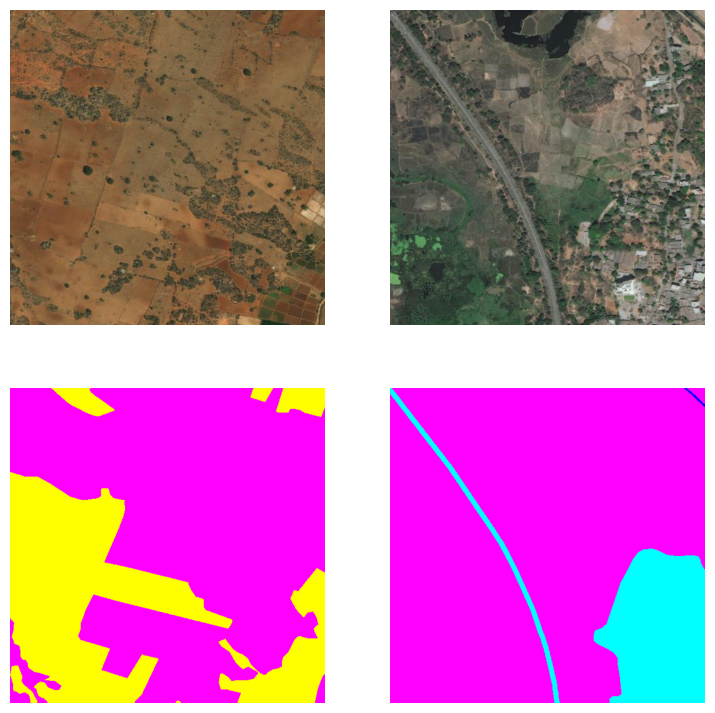

In [9]:
figure = plt.figure(figsize=(9, 9))
rows, cols = 2, 2
for i in range(1, cols+1):
    sample_idx = i+200
    image, color, classs, label = train_data[sample_idx]
    image = np.transpose(image.to(torch.uint8), (1, 2, 0))
    figure.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze())
    plt.axis("off")
    color = np.transpose(color.to(torch.uint8), (1, 2, 0))
    figure.add_subplot(rows, cols, i+cols)
    plt.imshow(color.squeeze())
    plt.axis("off")
plt.show()

In [11]:
class en_de(nn.Module):
    def __init__(self):
        super(en_de, self).__init__()
        self.encoder = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features[:31]
        self.fcn32 = nn.Sequential(nn.Conv2d(512, 512, 3, padding='same'), nn.ReLU(),
                                   nn.Conv2d(512, 512, 3, padding='same'), nn.ReLU(),
                                   torch.nn.ConvTranspose2d(512, 7, kernel_size=(32, 32) ,stride=(32, 32)))
    def forward(self, x):
        x = self.encoder(x)
        x = self.fcn32(x)
        return x
    
model_ende = en_de()
model_ende

en_de(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# model_ende = torch.load('model_ende_175.pth')
model_ende.to(device)

best_model_ende = en_de()
best_acc = 0.0
# best_acc = 0.7182
# best_model_ende = torch.load('best_model_ende.pth')

record = {'train_loss':[], 'train_acc':[],'test_loss':[], 'test_acc':[], 'test_miou':[]}
# record_load = np.load('record.npz')
# record['train_loss'] = record_load['train_loss'].tolist()
# record['train_acc'] = record_load['train_acc'].tolist()
# record['test_loss'] = record_load['test_loss'].tolist()
# record['test_acc'] = record_load['test_acc'].tolist()
# record['test_miou'] = record_load['test_miou'].tolist()

cuda:0


In [14]:
def train_loop(dataloader, model, loss_fn, optimizer, scheduler=None):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    step = int(num_batches/10)
    train_loss, train_acc = 0, 0
    for batch, (X, _, c, y) in enumerate(dataloader):
        X, y, c = X.float(), y.float(), c.float()
        X, y, c = X.to(device), y.to(device), c.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        batch_acc = (pred.argmax(1)==y.argmax(1)).type(torch.float).sum().item()
        train_acc += batch_acc
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % step == 0:
            loss, current = loss.item(), (batch+1)*len(X)
            print(f"loss: {loss:>7f}, acc: {(100*batch_acc/(batch_size*512*512)):>0.1f}%  [{current:>5d}/{size:>5d}]")
    if scheduler is not None:
        scheduler.step()
    train_loss /= num_batches
    train_acc /= (size*512*512)
    print(f"Train | Avg_loss: {train_loss:>8f}, Accuracy: {(100*train_acc):>0.1f}%")
    return train_loss, train_acc

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_acc = 0, 0
    with torch.no_grad():
        for X, _, c, y in dataloader:
            X, y, c = X.float(), y.float(), c.float()
            X, y, c = X.to(device), y.to(device), c.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_acc += (pred.argmax(1)==y.argmax(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    test_acc /= (size*512*512)
    print(f"Test  | Avg_loss: {test_loss:>8f}, Accuracy: {(100*test_acc):>0.1f}%\n")
    return test_loss, test_acc

In [15]:
learning_rate = 1e-4
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ende.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

In [ ]:
img_path = 'hw1_data/p2_data/validation/'
temp_path = 'hw1_data/p2_data/pred_temp/'
pred_path = 'hw1_data/p2_data/val_pred/'

In [17]:
epochs = 100
for e in range(1, epochs+1):
    ee = len(record['train_loss'])+1
    print(f"Epoch {ee}\n------------------------------------------")
    train_loss, train_acc = train_loop(train_dataloader, model_ende, loss_fn, optimizer, scheduler)
    test_loss, test_acc = test_loop(test_dataloader, model_ende, loss_fn)
    record['train_loss'].append(train_loss)
    record['train_acc'].append(train_acc)
    record['test_loss'].append(test_loss)
    record['test_acc'].append(test_acc)
    test_miou = seg_pred(str(ee), model_ende, img_path, temp_path)
    record['test_miou'].append(test_miou)
    if test_miou > best_acc:
        best_acc = test_miou
        best_model_ende.load_state_dict(model_ende.state_dict())
    if (ee%25 == 0) or (ee == 1):
        torch.save(model_ende, f'model_ende_{ee}.pth')
        torch.save(best_model_ende, f'best_model_ende.pth')
        np.savez(f'record', train_loss=np.array(record['train_loss']), train_acc=np.array(record['train_acc']),
                 test_loss=np.array(record['test_loss']), test_acc=np.array(record['test_acc']), test_miou=np.array(record['test_miou']))
print("Done!")

Epoch 1
------------------------------------------
loss: 1.975322, acc: 15.0%  [    4/ 2000]
loss: 1.357715, acc: 61.7%  [  204/ 2000]
loss: 1.250798, acc: 51.2%  [  404/ 2000]
loss: 0.719527, acc: 68.9%  [  604/ 2000]
loss: 0.911087, acc: 58.7%  [  804/ 2000]
loss: 0.347329, acc: 91.3%  [ 1004/ 2000]
loss: 1.225467, acc: 44.4%  [ 1204/ 2000]
loss: 0.061849, acc: 99.2%  [ 1404/ 2000]
loss: 1.382363, acc: 43.4%  [ 1604/ 2000]
loss: 1.114839, acc: 54.5%  [ 1804/ 2000]
Train | Avg_loss: 0.936878, Accuracy: 68.8%
Test  | Avg_loss: 0.740602, Accuracy: 75.2%

class #0 : 0.64594
class #1 : 0.75619
class #2 : 0.00040
class #3 : 0.56742
class #4 : 0.17582
class #5 : 0.00006

mean_iou: 0.357637

Epoch 2
------------------------------------------
loss: 0.395069, acc: 91.0%  [    4/ 2000]
loss: 0.506640, acc: 83.9%  [  204/ 2000]
loss: 0.343563, acc: 91.1%  [  404/ 2000]
loss: 0.812070, acc: 66.8%  [  604/ 2000]
loss: 0.157622, acc: 96.6%  [  804/ 2000]
loss: 0.636374, acc: 77.4%  [ 1004/ 2000]
lo

class #0 : 0.72578
class #1 : 0.87460
class #2 : 0.28817
class #3 : 0.79468
class #4 : 0.73556
class #5 : 0.67267

mean_iou: 0.681908

Epoch 13
------------------------------------------
loss: 0.087009, acc: 96.7%  [    4/ 2000]
loss: 0.171577, acc: 94.0%  [  204/ 2000]
loss: 0.095393, acc: 96.5%  [  404/ 2000]
loss: 0.152818, acc: 94.7%  [  604/ 2000]
loss: 0.062129, acc: 97.5%  [  804/ 2000]
loss: 0.175626, acc: 94.6%  [ 1004/ 2000]
loss: 0.324126, acc: 89.3%  [ 1204/ 2000]
loss: 0.057781, acc: 98.1%  [ 1404/ 2000]
loss: 0.191919, acc: 93.2%  [ 1604/ 2000]
loss: 0.088727, acc: 96.5%  [ 1804/ 2000]
Train | Avg_loss: 0.163078, Accuracy: 94.1%
Test  | Avg_loss: 0.417223, Accuracy: 87.2%

class #0 : 0.75849
class #1 : 0.87227
class #2 : 0.30634
class #3 : 0.79033
class #4 : 0.73543
class #5 : 0.66814

mean_iou: 0.688501

Epoch 14
------------------------------------------
loss: 0.083749, acc: 97.5%  [    4/ 2000]
loss: 0.213177, acc: 92.6%  [  204/ 2000]
loss: 0.152368, acc: 94.1%  [  40

loss: 0.043370, acc: 98.5%  [ 1804/ 2000]
Train | Avg_loss: 0.177543, Accuracy: 93.8%
Test  | Avg_loss: 0.533728, Accuracy: 87.6%

class #0 : 0.74554
class #1 : 0.87459
class #2 : 0.30771
class #3 : 0.80682
class #4 : 0.73196
class #5 : 0.67041

mean_iou: 0.689505

Epoch 25
------------------------------------------
loss: 0.022411, acc: 99.2%  [    4/ 2000]
loss: 0.125686, acc: 95.2%  [  204/ 2000]
loss: 0.048892, acc: 98.3%  [  404/ 2000]
loss: 0.110492, acc: 95.1%  [  604/ 2000]
loss: 0.041944, acc: 98.2%  [  804/ 2000]
loss: 0.078751, acc: 96.8%  [ 1004/ 2000]
loss: 0.056195, acc: 97.8%  [ 1204/ 2000]
loss: 0.053029, acc: 97.9%  [ 1404/ 2000]
loss: 0.026900, acc: 98.9%  [ 1604/ 2000]
loss: 0.015518, acc: 99.4%  [ 1804/ 2000]
Train | Avg_loss: 0.058634, Accuracy: 97.7%
Test  | Avg_loss: 0.562705, Accuracy: 87.7%

class #0 : 0.75053
class #1 : 0.87711
class #2 : 0.30649
class #3 : 0.80894
class #4 : 0.74601
class #5 : 0.67722

mean_iou: 0.694383

Epoch 26
-----------------------------

KeyboardInterrupt: 

In [ ]:
# 0（青色：011）城市土地
# 1（黃色：110）農業用地
# 2（紫色：101）牧場
# 3（綠色：010）林地
# 4（藍色：001）水
# 5（白色：111）荒地
# 6（黑色：000）未知

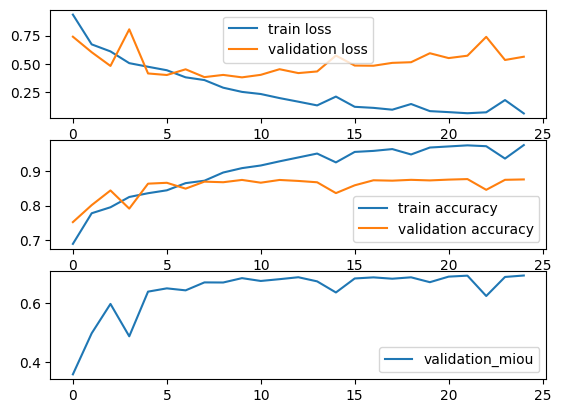

In [20]:
# plt.figure(figsize=(9, 9))
plt.subplot(311)
plt.plot(np.arange(len(record['train_loss'])), record['train_loss'], np.arange(len(record['test_loss'])), record['test_loss'])
plt.legend(['train loss', 'validation loss'])
plt.subplot(312)
plt.plot(np.arange(len(record['train_acc'])), record['train_acc'], np.arange(len(record['test_acc'])), record['test_acc'])
plt.legend(['train accuracy', 'validation accuracy'])
plt.subplot(313)
plt.plot(np.arange(len(record['test_miou'])), record['test_miou'])
plt.legend(['validation_miou', 'validation accuracy'])
plt.show()

In [19]:
max(record['test_miou'])

0.6943830307321381

In [22]:
torch.save(model_ende, 'model_ende.pth')
torch.save(best_model_ende, 'best_model_ende.pth')
np.savez(f'record', train_loss=np.array(record['train_loss']), train_acc=np.array(record['train_acc']),
           test_loss=np.array(record['test_loss']), test_acc=np.array(record['test_acc']), test_miou=np.array(record['test_miou']))

In [21]:
seg_pred('test', best_model_ende.to(device), img_path, temp_path)

class #0 : 0.75053
class #1 : 0.87711
class #2 : 0.30649
class #3 : 0.80894
class #4 : 0.74601
class #5 : 0.67722

mean_iou: 0.694383



0.6943830307321381